# Anaylsis Bike Sharing Data - Anonymised

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib as plt
%matplotlib inline
from sqlalchemy import create_engine
import requests
import time

import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from geopandas.tools import sjoin
import geoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis - Anonymised

This analysis is based on the anonymised dataset and does not incorporate information on single providers or bikes.

### setup

In [3]:
df = pd.read_csv('../../data/pseudonomysed.csv', parse_dates=['starttime','endtime', 'duration'], index_col='id.1')

In [4]:
df.duration = df.endtime - df.starttime

In [5]:
# day of the year
df['yday'] = df.starttime.apply(lambda x: x.timetuple().tm_yday)

# hour of the day
df['dhour'] = df.starttime.apply(lambda x: x.time().hour)

# "hour of the year"
df['yhour'] = df.dhour + (df.yday * 24)

# day of week
df['dweek'] = df.starttime.apply(lambda x: x.weekday())

# "hour of the week"
df['whour'] = df.dhour + (df.dweek * 24)

# calendarweek
df['calweek'] = df.starttime.apply(lambda x: x.isocalendar()[1])

#### exploration

In [6]:
df.describe()

,id,start_lat,start_lng,end_lat,end_lng,distance,duration,speed,yday,dhour,yhour,dweek,whour,calweek
count,285811.000000,285811.000000,285811.000000,285811.000000,285811.000000,285811.000000,285811,285811.000000,285811.000000,285811.000000,285811.000000,285811.000000,285811.000000,285811.000000
mean,142905.000000,52.509603,13.394017,52.509515,13.394047,2865.523917,0 days 01:36:41.750457,6.106679,144.106546,14.189363,3472.746465,2.915122,84.152296,21.170203
std,82506.673231,0.017989,0.044259,0.018038,0.044446,2078.274910,0 days 03:55:43.362898,3.736395,28.772640,5.346085,690.510794,1.961392,47.326965,4.107408
min,0.000000,52.360000,13.011000,52.339000,13.011000,200.100000,0 days 00:00:00,0.008346,91.000000,0.000000,2197.000000,0.000000,0.000000,14.000000
25%,71452.500000,52.497000,13.367000,52.497000,13.366000,1335.300000,0 days 00:15:00,3.355459,116.000000,10.000000,2801.000000,1.000000,42.000000,17.000000
50%,142905.000000,52.510000,13.398000,52.510000,13.398000,2365.800000,0 days 00:30:00,6.188219,148.000000,15.000000,3571.000000,3.000000,85.000000,22.000000
75%,214357.500000,52.523000,13.427000,52.523000,13.427000,3942.200000,0 days 00:45:00,8.644240,169.000000,18.000000,4070.000000,5.000000,123.000000,25.000000
max,285810.000000,52.683000,13.752000,52.683000,13.703000,34504.700000,1 days 00:00:00,29.984768,192.000000,23.000000,4622.000000,6.000000,167.000000,28.000000


## Distance

In [6]:
## sum of kilometers driven each day on average

In [7]:
df.groupby('yday').sum().distance.describe()

count    1.020000e+02
mean     8.029395e+06
std      3.108836e+06
min      9.274327e+05
25%      6.296909e+06
50%      8.490419e+06
75%      1.026586e+07
max      1.398049e+07
Name: distance, dtype: float64

In [8]:
## average distance per ride (in cleaning script rides  < 200 m were removed)

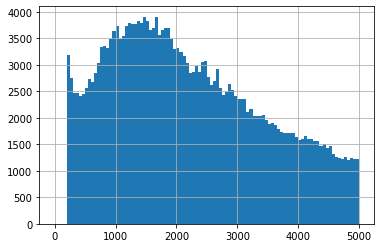

In [94]:
df.distance.hist(range=(0,5000), bins=100)

In [9]:
df.distance.describe()

count    285811.000000
mean       2865.523917
std        2078.274910
min         200.100000
25%        1335.300000
50%        2365.800000
75%        3942.200000
max       34504.700000
Name: distance, dtype: float64

## Duration

In [10]:
# average duration per ride

In [11]:
df.duration.describe()

count                    285811
mean     0 days 01:36:41.750457
std      0 days 03:55:43.362898
min             0 days 00:00:00
25%             0 days 00:15:00
50%             0 days 00:30:00
75%             0 days 00:45:00
max             1 days 00:00:00
Name: duration, dtype: object

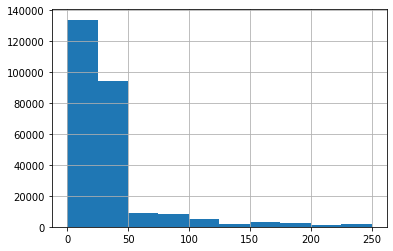

In [12]:
# histogram of minutes spent on trip
df.duration.apply(lambda x: x.seconds / 60).hist(range=(0,250))

In [13]:
# average trips duration by starting time

In [14]:
df.groupby('dhour').duration.describe()

,count,mean,std,min,25%,50%,75%,max
dhour,,,,,,,,
0,5512,0 days 02:01:05.475326,0 days 04:40:25.913429,0 days 00:00:00,0 days 00:15:00,0 days 00:15:00,0 days 00:30:00,1 days 00:00:00
1,3873,0 days 02:01:29.930286,0 days 04:33:07.527282,0 days 00:00:00,0 days 00:15:00,0 days 00:15:00,0 days 00:30:00,1 days 00:00:00
2,2439,0 days 01:51:48.118081,0 days 04:17:52.470713,0 days 00:00:00,0 days 00:15:00,0 days 00:15:00,0 days 00:30:00,1 days 00:00:00
3,1689,0 days 01:29:39.218472,0 days 03:39:36.359354,0 days 00:00:00,0 days 00:15:00,0 days 00:15:00,0 days 00:30:00,0 days 22:30:00
5,1485,0 days 01:29:44.242424,0 days 03:05:57.987338,0 days 00:00:00,0 days 00:15:00,0 days 00:15:00,0 days 00:45:00,0 days 23:15:00
6,3269,0 days 01:30:42.398286,0 days 03:02:47.347269,0 days 00:00:00,0 days 00:15:00,0 days 00:15:00,0 days 01:15:00,1 days 00:00:00
7,8707,0 days 01:49:50.766050,0 days 03:26:15.970087,0 days 00:00:00,0 days 00:15:00,0 days 00:30:00,0 days 00:45:00,1 days 00:00:00
8,18122,0 days 01:01:20.653349,0 days 02:31:43.201741,0 days 00:00:00,0 days 00:15:00,0 days 00:15:00,0 days 00:30:00,1 days 00:00:00
9,17574,0 days 01:16:11.389552,0 days 03:04:30.841590,0 days 00:00:00,0 days 00:15:00,0 days 00:15:00,0 days 00:30:00,1 days 00:00:00


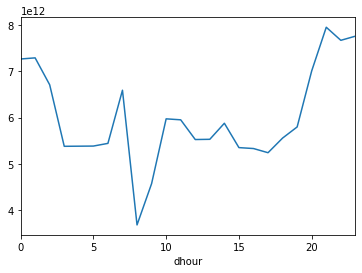

In [7]:
df.groupby('dhour').duration.describe()['mean'].plot()

## daily counts of trips

In [20]:
# daily average trips counts
df.groupby('yday').count().id.describe()

count     102.000000
mean     2802.068627
std      1034.713241
min       364.000000
25%      2268.000000
50%      3004.500000
75%      3455.500000
max      4746.000000
Name: id, dtype: float64

## count of trips each hour

In [21]:
counts = df.groupby(['yhour']).count()

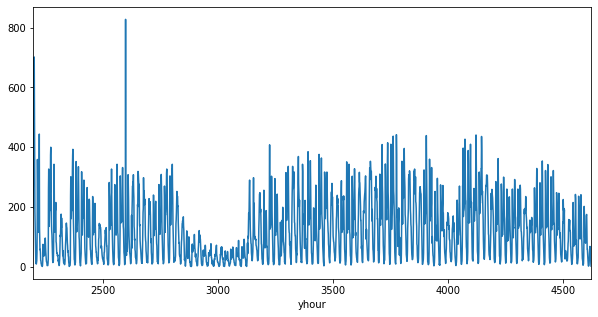

In [22]:
counts.id.plot(figsize=(10,5))

## How many trips start at what time?

In [23]:
# hour of day

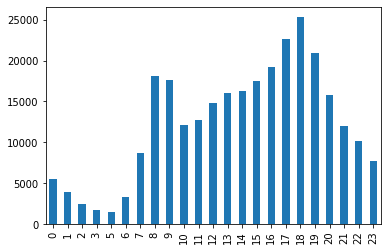

In [24]:
df.dhour.value_counts().sort_index().plot(kind='bar')

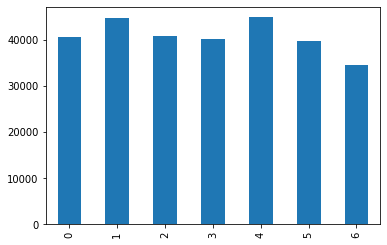

In [25]:
df.dweek.value_counts().sort_index().plot(kind='bar')

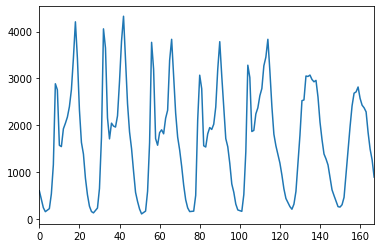

In [26]:
df.whour.value_counts().sort_index().plot()

In [27]:
# plot week of year

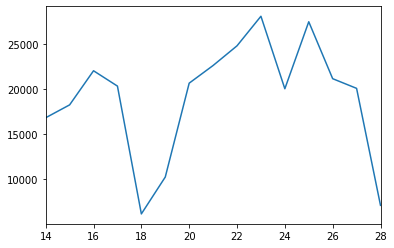

In [28]:
df.calweek.value_counts().sort_index().plot()

In [29]:
# plot day of year

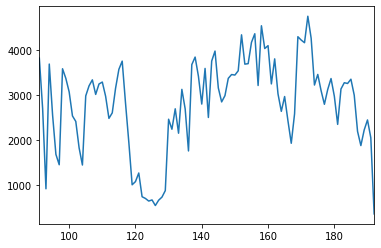

In [30]:
df.yday.value_counts().sort_index().plot()

## How many bikes are in use at what time?

In [53]:
# how many bikes are on a trip each hour?
def used_bikes(df):
    bikes_in_use = pd.DataFrame()

    start = df.sort_values('starttime').reset_index().loc[0,'starttime']
    end = df.sort_values('starttime').reset_index().loc[df.shape[0]-2, 'starttime']
    times= []
    while start < end:
        times.append(start)
        start += datetime.timedelta(hours=1)
    
    bikes_in_use['time'] = times
    bikes_in_use['total'] = bikes_in_use.time.apply(lambda x: df[
               (df.starttime <= x) & 
               (df.endtime > x)].id.unique().shape[0])

    # day of the year
    bikes_in_use['yday'] = bikes_in_use.time.apply(lambda x: x.timetuple().tm_yday)

    # hour of the day
    bikes_in_use['dhour'] = bikes_in_use.time.apply(lambda x: x.time().hour)

    # "hour of the year"
    bikes_in_use['yhour'] = bikes_in_use.dhour + (bikes_in_use.yday * 24)

    # day of week
    bikes_in_use['dweek'] = bikes_in_use.time.apply(lambda x: x.weekday())
    return bikes_in_use

In [54]:
in_use = used_bikes(df[(df.starttime > datetime.datetime(2019,6,1)) & (df.starttime < datetime.datetime(2019,6,10))].sort_values('starttime'))

In [55]:
in_use.describe()

,total,yday,dhour,yhour,dweek
count,216.000000,216.000000,216.000000,216.000,216.000000
mean,276.726852,156.000000,11.500000,3755.500,3.555556
std,90.847966,2.587987,6.938266,62.498,2.065591
min,22.000000,152.000000,0.000000,3648.000,0.000000
25%,226.000000,154.000000,5.750000,3701.750,2.000000
50%,272.500000,156.000000,11.500000,3755.500,4.000000
75%,332.000000,158.000000,17.250000,3809.250,5.000000
max,487.000000,160.000000,23.000000,3863.000,6.000000


On average 277 bikes are in use at the same time.

In [ ]:
# average bike use per time

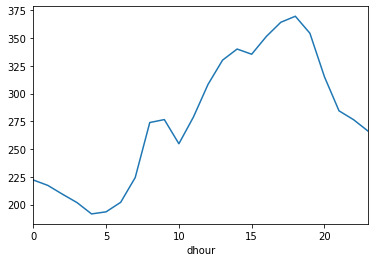

In [56]:
in_use.groupby('dhour').mean()['total'].plot()

#### speed of bikes

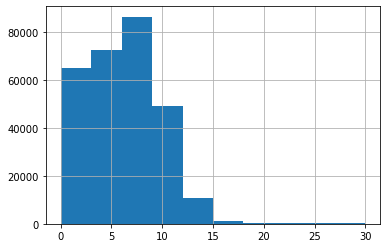

In [31]:
df['speed'].hist()

In [32]:
df['speed'].describe()

count    285811.000000
mean          6.106679
std           3.736395
min           0.008346
25%           3.355459
50%           6.188219
75%           8.644240
max          29.984768
Name: speed, dtype: float64

On average bikes ride with a speed of 6 km/h. 
Though, it has to be considered, that the process of renting and returning the bike is included within the time. Also: Many rides whith long renting times (multiple hours) and very slow speed indicate an error in the returning process or parking times.

## Geoanalysis 

#### Bike Availability: 
- Where are bikes available (per Planungsraum)? On average? On average weekdays / times?
- Distance between available bikes

#### Are there "hot spots" for pick up and drop off?

Start and Endpoints

In [8]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.start_lng, df.start_lat)]
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
# gdf = gdf.to_crs(epsg=25833)

In [9]:
geometry = [Point(xy) for xy in zip(df.end_lng, df.end_lat)]
gdf_end = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
# gdf_end = gdf_end.to_crs(epsg=25833)

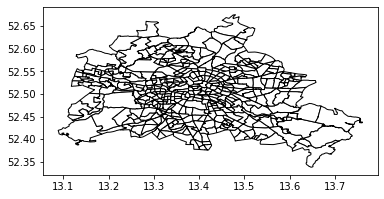

In [12]:
plr = gpd.read_file('lor_planungsraeume.geojson', encoding='utf-8')
# plr = plr.to_crs(epsg=25833)
base = plr.plot(color='white', edgecolor='black')

In [9]:
# map of startpoints
gdf.plot(ax=base, markersize=0.01, figsize=(20,20))

<Figure size 432x288 with 0 Axes>

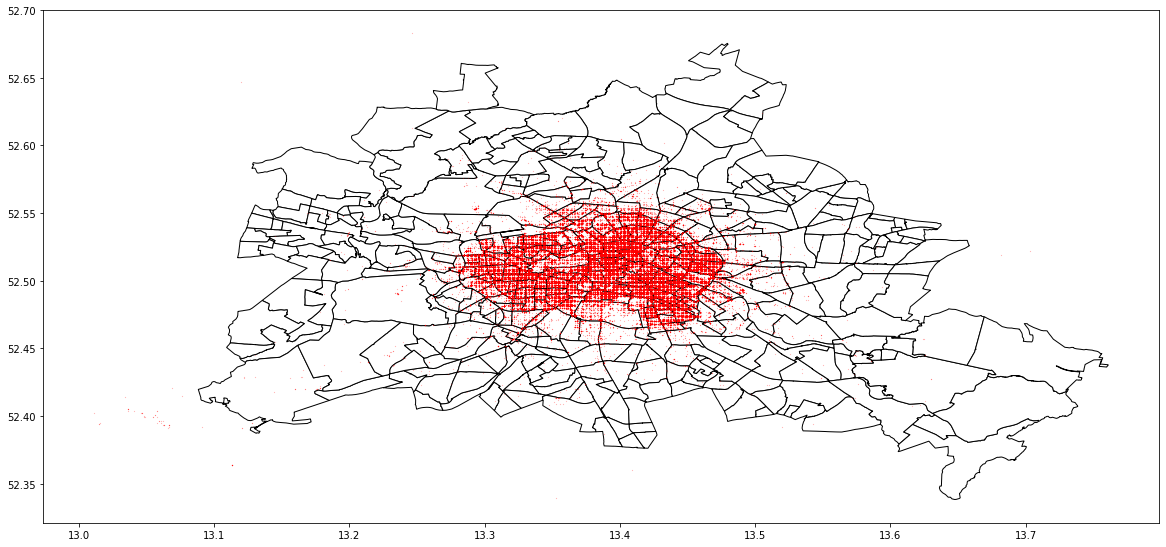

In [10]:
fig, ax = plt.pyplot.subplots(figsize=(20,20))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')
plr.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=0.01,)
plt.pyplot.show();

In [ ]:
# map of endpoints
gdf_end.plot(ax=base, markersize=0.01, figsize=(20,20))

In [ ]:
# map both
start = gdf.plot(ax=base, markersize=0.01, figsize=(20,20), color='red')
gdf_end.plot(ax=start, markersize=0.01, figsize=(20,20))

#### Heatmap

In [ ]:
# start
ax = geoplot.kdeplot(gdf,
                     shade=True, shade_lowest=False,
                     clip=plr.geometry, figsize=(10,20))
geoplot.polyplot(plr, ax=ax, zorder=1, figsize=(10,20))

In [ ]:
# TODO
# Heatmap by Time

In [ ]:
# endpoints
ax = geoplot.kdeplot(gdf_end,
                     shade=True, shade_lowest=False,
                     clip=plr.geometry, figsize=(20,20))
geoplot.polyplot(plr, ax=ax, zorder=1, figsize=(20,20))

In [11]:
start_in_plr = sjoin(plr, gdf, how='inner')

counts = start_in_plr.groupby('spatial_name').count()
counts.rename(columns={'gml_id':'ride_count'}, inplace=True)

start_in_plr = plr.set_index('spatial_name').join(counts['ride_count'], how='inner')

In [292]:
# inner ring bounding box
lat_point_list = [52.553, 52.458,52.553, 52.458]
lon_point_list = [13.277, 13.511, 13.511, 13.277]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = {'init': 'epsg:4326'}
berlin_bbox = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])   

bounding_box = berlin_bbox.envelope
bounding_box = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

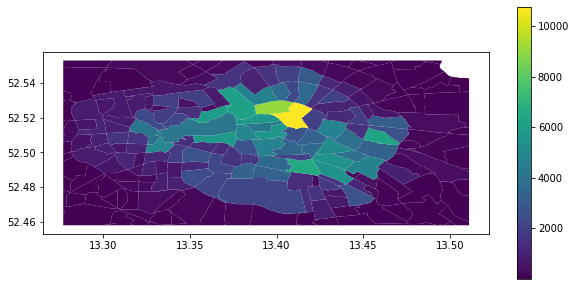

In [293]:
inner_ring = gpd.overlay(bounding_box, start_in_plr, how='intersection')

inner_ring.crs = {'init':'epsg:25833'}
inner_ring = inner_ring.to_crs(epsg=25833)

fig, ax = plt.pyplot.subplots(1, 1, figsize=(10,5))
inner_ring.plot(column='ride_count', ax=ax, legend=True)

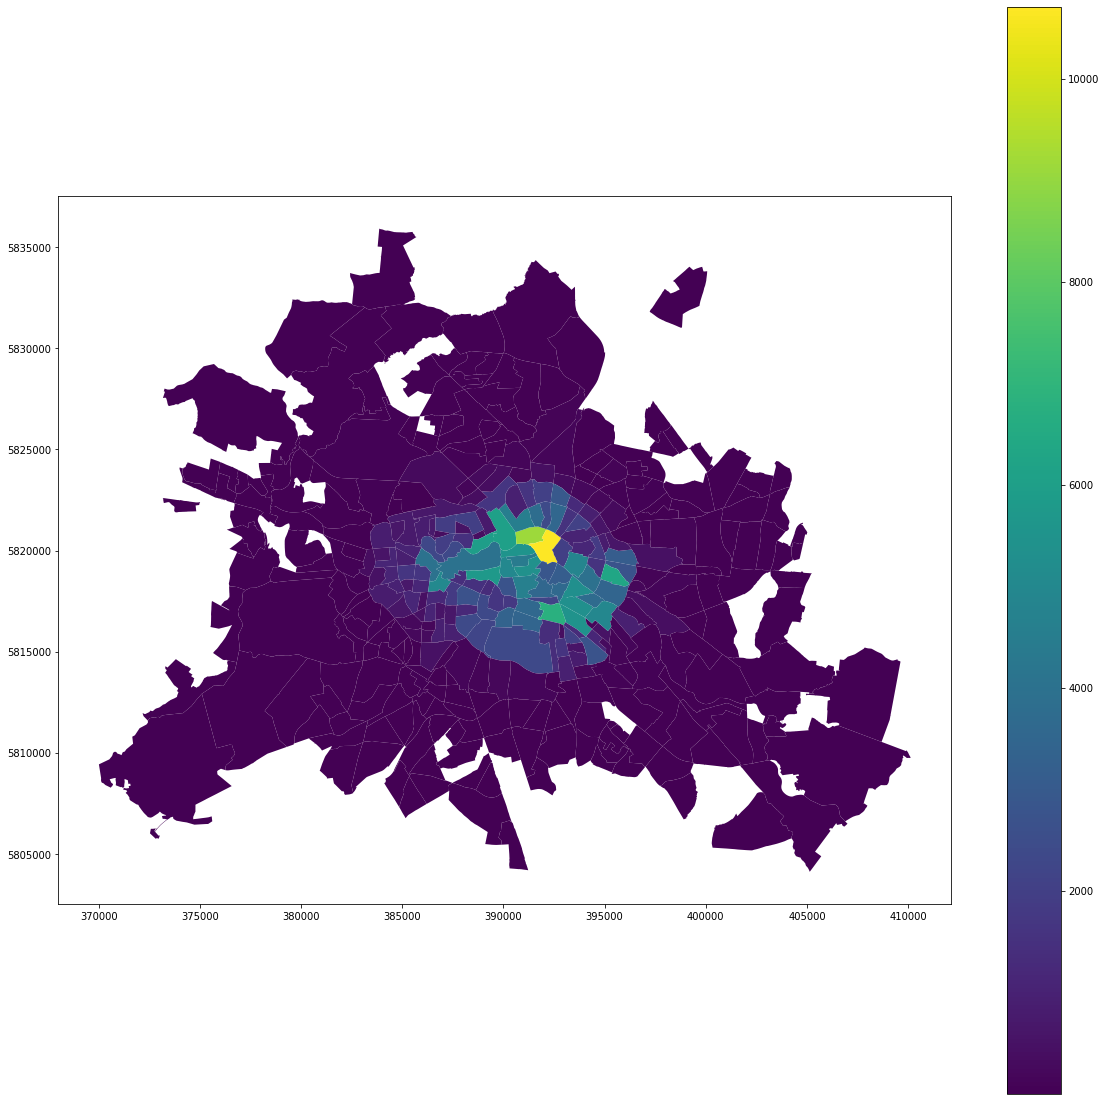

In [312]:
end_in_plr = sjoin(plr, gdf_end, how='inner')

counts = end_in_plr.groupby('spatial_name').count()
counts.rename(columns={'gml_id':'ride_count'}, inplace=True)

end_in_plr = plr.set_index('spatial_name').join(counts['ride_count'], how='inner')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

end_in_plr = end_in_plr.to_crs(epsg=25833)

fig, ax = plt.pyplot.subplots(1, 1, figsize=(20,20))
end_in_plr.plot(column='ride_count', ax=ax, legend=True)

In [38]:
### How many rides start in each Bezirk?

In [13]:
start_in_bz = sjoin(plr, gdf, how='inner')
start_in_bz.groupby('BEZNAME').count().sort_values('gml_id')

,gml_id,spatial_name,spatial_alias,spatial_type,PLRNAME,BZRNAME,PGRNAME,DATUM,SHAPE_AREA,geometry,...,duration,speed,starttime,endtime,yday,dhour,yhour,dweek,whour,calweek
BEZNAME,,,,,,,,,,,,,,,,,,,,,
Marzahn-Hellersdorf,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
Spandau,83,83,83,83,83,83,83,83,83,83,...,83,83,83,83,83,83,83,83,83,83
Reinickendorf,283,283,283,283,283,283,283,283,283,283,...,283,283,283,283,283,283,283,283,283,283
Steglitz-Zehlendorf,341,341,341,341,341,341,341,341,341,341,...,341,341,341,341,341,341,341,341,341,341
Lichtenberg,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849,...,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849
Treptow-Köpenick,6279,6279,6279,6279,6279,6279,6279,6279,6279,6279,...,6279,6279,6279,6279,6279,6279,6279,6279,6279,6279
Tempelhof-Schöneberg,17934,17934,17934,17934,17934,17934,17934,17934,17934,17934,...,17934,17934,17934,17934,17934,17934,17934,17934,17934,17934
Pankow,19815,19815,19815,19815,19815,19815,19815,19815,19815,19815,...,19815,19815,19815,19815,19815,19815,19815,19815,19815,19815
Neukölln,20055,20055,20055,20055,20055,20055,20055,20055,20055,20055,...,20055,20055,20055,20055,20055,20055,20055,20055,20055,20055


In [14]:
start_in_bz.groupby('PLRNAME').count().sort_values('gml_id',ascending=False).head()

,gml_id,spatial_name,spatial_alias,spatial_type,BZRNAME,PGRNAME,BEZNAME,DATUM,SHAPE_AREA,geometry,...,duration,speed,starttime,endtime,yday,dhour,yhour,dweek,whour,calweek
PLRNAME,,,,,,,,,,,,,,,,,,,,,
Alexanderplatzviertel,10709,10709,10709,10709,10709,10709,10709,10709,10709,10709,...,10709,10709,10709,10709,10709,10709,10709,10709,10709,10709
Oranienburger Straße,9136,9136,9136,9136,9136,9136,9136,9136,9136,9136,...,9136,9136,9136,9136,9136,9136,9136,9136,9136,9136
Graefekiez,6779,6779,6779,6779,6779,6779,6779,6779,6779,6779,...,6779,6779,6779,6779,6779,6779,6779,6779,6779,6779
Boxhagener Platz,6348,6348,6348,6348,6348,6348,6348,6348,6348,6348,...,6348,6348,6348,6348,6348,6348,6348,6348,6348,6348
Charit¿viertel,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061,...,6061,6061,6061,6061,6061,6061,6061,6061,6061,6061


### Prepare Data vor Leaflet Viz

In [15]:
start_counts_plr = start_in_bz.groupby('spatial_name').count()
start_counts_plr = start_counts_plr.join(plr.set_index('spatial_name'), rsuffix='_r')
start_counts_plr.reset_index(inplace=True)
start_counts_plr = start_counts_plr[['spatial_name','gml_id', 'geometry_r', 'PLRNAME_r']]
start_counts_plr.rename(columns={'gml_id':'counts', 'geometry_r':'geometry', 'PLRNAME_r': 'PLRNAME'}, inplace = True)

In [18]:
start_counts_plr.geometry = flatten_gdf_geometry(start_counts_plr, 'Polygon')

In [36]:
gpd.GeoDataFrame(start_counts_plr).to_file('start_counts.geojson', driver='GeoJSON', encoding='utf-8')

In [17]:
def flatten_gdf_geometry(gdf, geom_type):
    geometry = gdf.geometry
    flattened_geometry = []

    flattened_gdf = gpd.GeoDataFrame()

    for geom in geometry:
        if geom.type in ['GeometryCollection', 'MultiPoint', 'MultiLineString', 'MultiPolygon']:
            for subgeom in geom:
                if subgeom.type==geom_type:
                    flattened_geometry.append(subgeom)
        else:
            if geom.type==geom_type:
                flattened_geometry.append(geom)

    flattened_gdf.geometry=flattened_geometry

    return flattened_gdf

### Prepare json File for "Austin-style" Viz

In [211]:
# startcell
df_viz = sjoin(plr, gdf, how='right')[['starttime', 'duration', 'endtime', 'spatial_name', 'end_lat', 'end_lng', 'geometry']]
df_viz.rename(columns={'spatial_name': 'cell_id_start'}, inplace=True)
geometry = [Point(xy) for xy in zip(df_viz.end_lng, df_viz.end_lat)]
gdf_end = gpd.GeoDataFrame(df_viz, crs=crs, geometry=geometry)

#endcell
df_viz = sjoin(plr, gdf_end, how='right')[['starttime', 'duration', 'endtime', 'cell_id_start', 'spatial_name']]
df_viz.rename(columns={'spatial_name': 'cell_id_end',  'starttime': 'timestamp', 'endtime':'end_timestamp', 'cell_id': 'cell_id_end'}, inplace=True)
df_viz.to_json('viz-formatted.json', orient='records')

## Include further data

#### Intersect with subway stops

In [27]:
gdf_vbb = gpd.read_file('../../data/haltestellen-berlin.geojson', encoding='utf-8')
#gdf_vbb.plot(figsize=(20,15))

In [28]:
gdf_vbb_points =  gpd.read_file('../../data/haltestellen-berlin.geojson', encoding='utf-8')

### How many rides start and stop at subway stops?

In [29]:
gdf_vbb = gdf_vbb.to_crs('+init=epsg:3395')

In [30]:
# create 100 meter radiuses around the subwaystops
gdf_vbb['geometry'] = gdf_vbb.geometry.buffer(100)

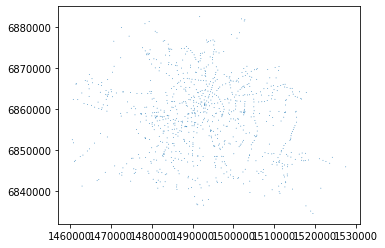

In [31]:
gdf_vbb.plot()

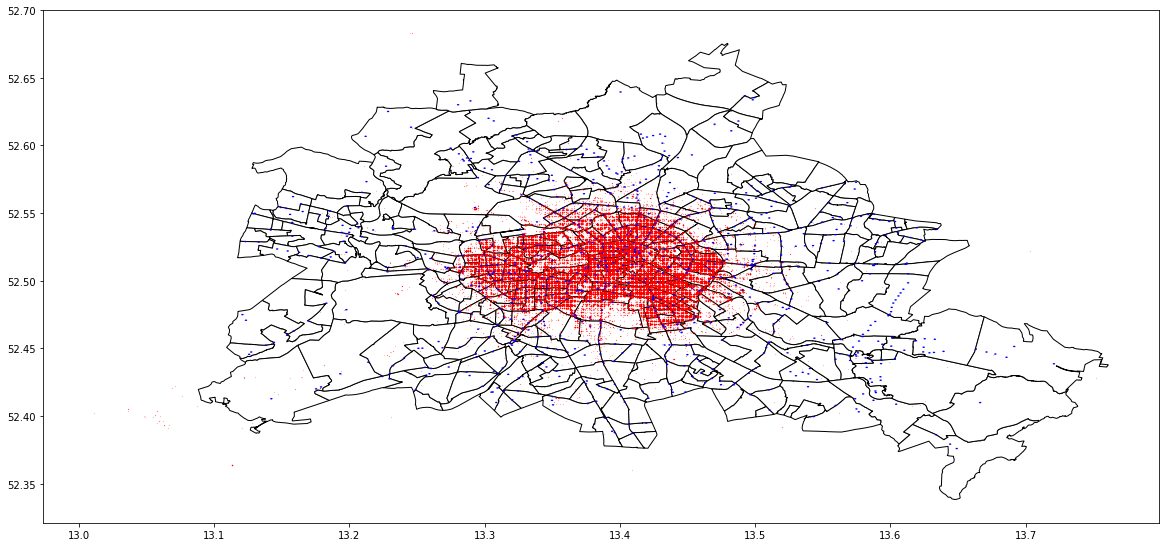

In [138]:
fig, ax = plt.pyplot.subplots(figsize=(20,20))

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')
plr.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=0.01,)
gdf_vbb.plot(ax=ax, color='blue', markersize=0.01,)
plt.pyplot.show();

In [32]:
# intersect subwaystops and startpoints
gdf_vbb = gdf_vbb.to_crs('+init=epsg:4326')

In [33]:
gdf_vbb_points = gdf_vbb_points.to_crs('+init=epsg:4326')

In [34]:
start_at_subway = sjoin(gdf_vbb[['ID', 'geometry','Bauwerk Name']], gdf, how='inner')

counts = start_at_subway.groupby('ID').count()
counts.rename(columns={'Bauwerk Name':'start_count'}, inplace=True)

start_at_subway = gdf_vbb_points.set_index('ID').join(counts['start_count'], how='inner')

C:\Users\Alexandra\AppData\Local\Continuum\anaconda3\envs\analysis\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


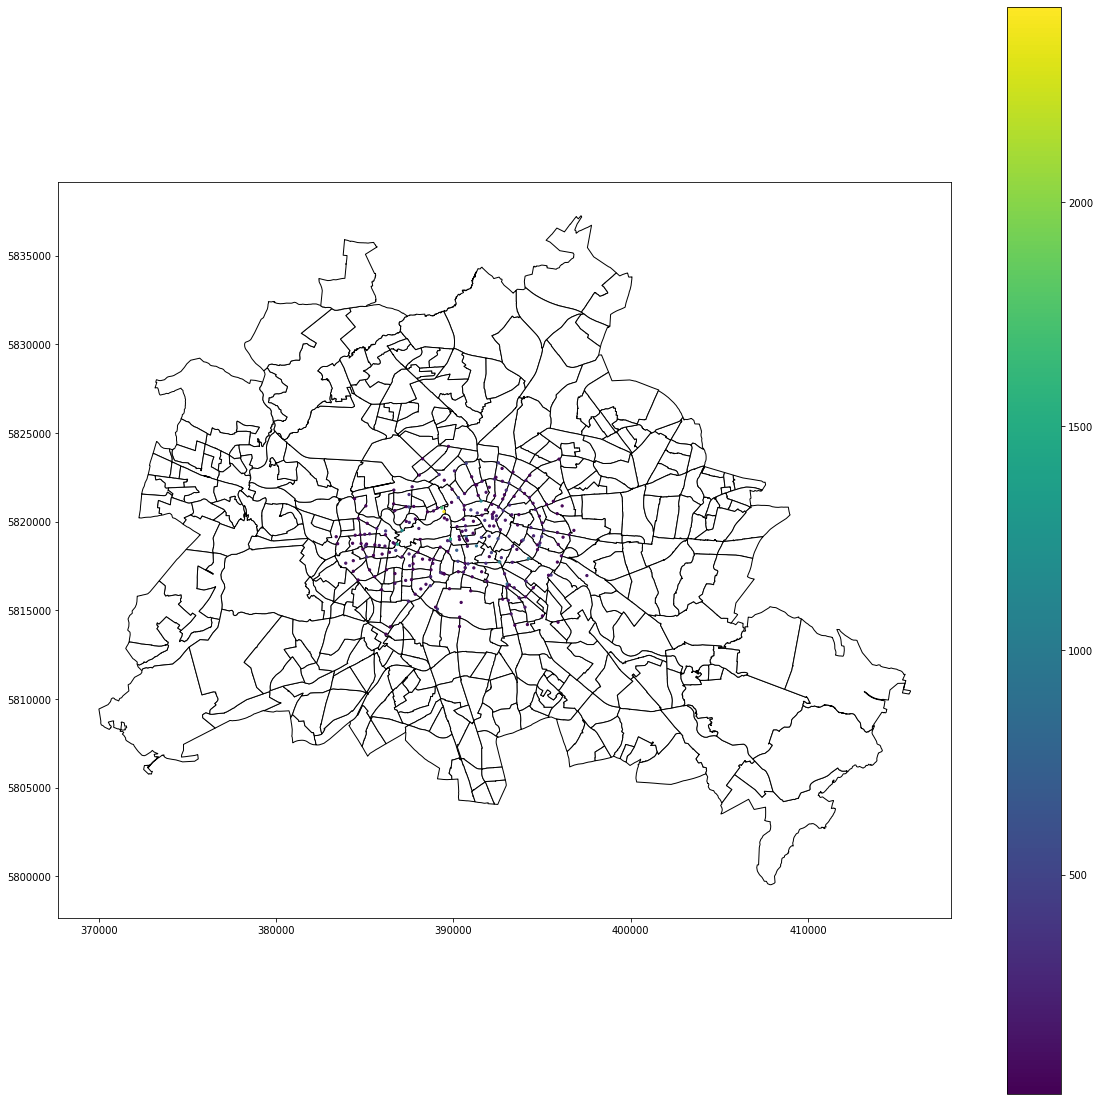

In [74]:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

start_at_subway = start_at_subway.to_crs(epsg=25833)

fig, ax = plt.pyplot.subplots(1, 1, figsize=(20,20))
plr.to_crs(epsg=25833).plot(ax=ax, color='white', edgecolor='black')
start_at_subway[start_at_subway.start_count > 10].plot(column='start_count', ax=ax, legend=True, markersize=5)

In [35]:
start_at_subway = start_at_subway.to_crs('+init=epsg:4326')
start_at_subway.reset_index()[['ID','start_count', 'geometry', 'Bauwerk Name']].to_file('start_at_subway.geojson', driver='GeoJSON', encoding='utf-8')

In [84]:
start_at_subway.sort_values('start_count', ascending=False).head(10)

,Bauwerk Name,Bauwerkselement Name,Bauwerkselement Typ,Bauwerkselement Nummer,Bauwerkselement Niveau,X-Koordinate,Y-Koordinate,Bauwerksreferenzort Nummer,geometry,start_count
ID,,,,,,,,,,
900003205,Washingtonplatz/Hauptbahnhof (Berlin),Washingtonplatz/Hauptbahnhof (Berlin),Bauwerk,303,None,"13,370708","52,523966",3205,(POINT (13.370708 52.52396600000001)),2436
900003201,S+U Berlin Hauptbahnhof,S+U Berlin Hauptbahnhof,Bauwerk,258,None,"13,368924","52,525847",3201,(POINT (13.368924 52.52584699999998)),1696
900100022,S Potsdamer Platz Bhf/Vo�str. (Berlin),S Potsdamer Platz Bhf/Vo�str. (Berlin),Bauwerk,288,None,"13,376656","52,510147",100022,(POINT (13.376656 52.510147)),1482
900023201,S+U Zoologischer Garten Bhf (Berlin),S+U Zoologischer Garten Bhf (Berlin),Bauwerk,2,None,"13,332707","52,506921",23201,(POINT (13.332707 52.50692099999999)),1428
900003103,S Tiergarten (Berlin),S Tiergarten (Berlin),Bauwerk,224,None,"13,336241","52,513959",3103,(POINT (13.336241 52.51395899999999)),1198
900100023,U Rosenthaler Platz (Berlin),U Rosenthaler Platz (Berlin),Bauwerk,115,None,"13,401393","52,529781",100023,(POINT (13.401393 52.52978099999999)),1123
900013102,U Kottbusser Tor (Berlin),U Kottbusser Tor (Berlin),Bauwerk,102,None,"13,417748","52,499047",13102,(POINT (13.417748 52.499047)),1090
900014102,U Schlesisches Tor (Berlin),U Schlesisches Tor (Berlin),Bauwerk,100,None,"13,441791","52,501147",14102,(POINT (13.441791 52.501147)),1015
900012104,Lindenstr./Oranienstr. (Berlin),Lindenstr./Oranienstr. (Berlin),Bauwerk,1434,None,"13,398369","52,506962",12104,(POINT (13.398369 52.50696199999999)),912


#### weather data

#### nextbike stations: with and without docking station: how many rides start from / end at a docking station